<a href="https://colab.research.google.com/github/arsyidarmawan/CNN/blob/main/epoch%20-%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [5]:
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import random
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

# Extract Data

In [6]:
# unzipping dataset
files = zf.ZipFile("dataset-sampah.zip",'r')
files.extractall()
files.close()

In [7]:
os.listdir(os.path.join(os.getcwd(),"dataset-sampah"))

['paper', 'trash', 'metal', 'plastic', 'cardboard']

In [8]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

In [9]:
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)

In [10]:
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [11]:
# separating train, valid, dan test images into 3 different folders

## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-sampah',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [12]:
# path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [13]:
from fastai.vision import *
from fastai.metrics import error_rate

In [14]:
# augment the data to compare result horizontally and vertically
tfms = get_transforms(do_flip=True,flip_vert=True)
# get batch size = 10 (how many images that will be trained at a time)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=10)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [15]:
data

ImageDataBunch;

Train: LabelList (1012 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /content/data;

Valid: LabelList (505 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /content/data;

Test: LabelList (509 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [16]:
data.classes

['cardboard', 'metal', 'paper', 'plastic', 'trash']

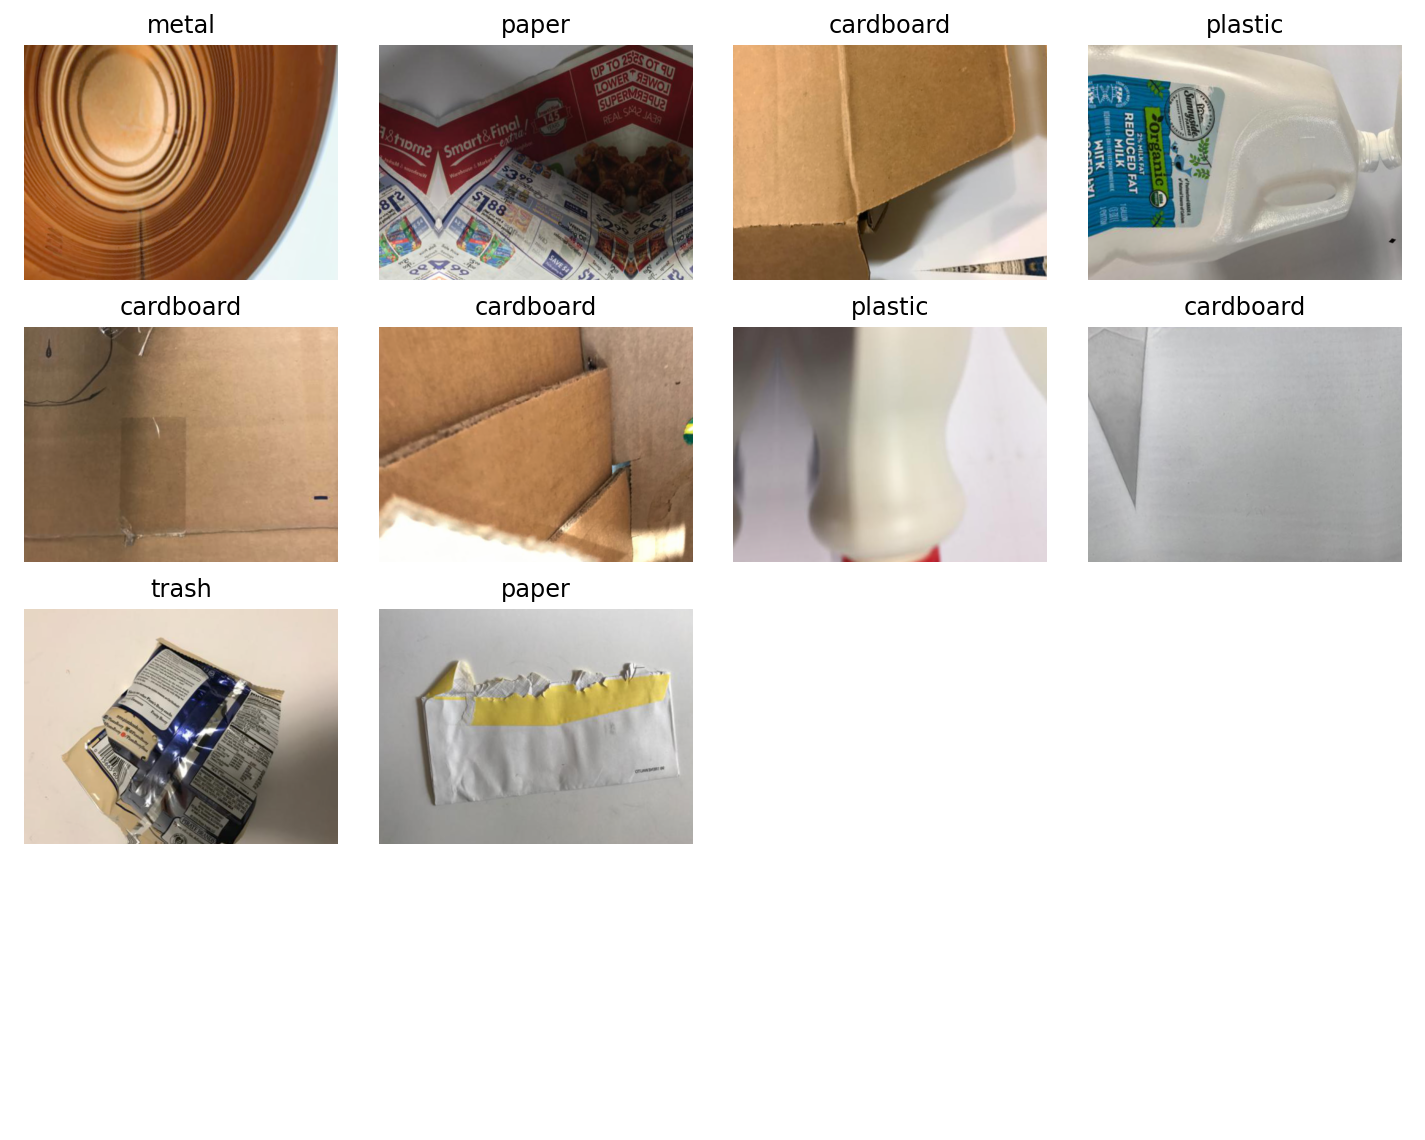

In [17]:
# example of batch data (images that wil be trained together at a time)
data.show_batch(rows=4,figsize=(10,8))

# Training

In [18]:
# create cnn with resnet34
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
# find the learning rate (gradient descent)
learn.lr_find(start_lr=1e-6,end_lr=1e1)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.47E-05
Min loss divided by 10: 2.57E-03


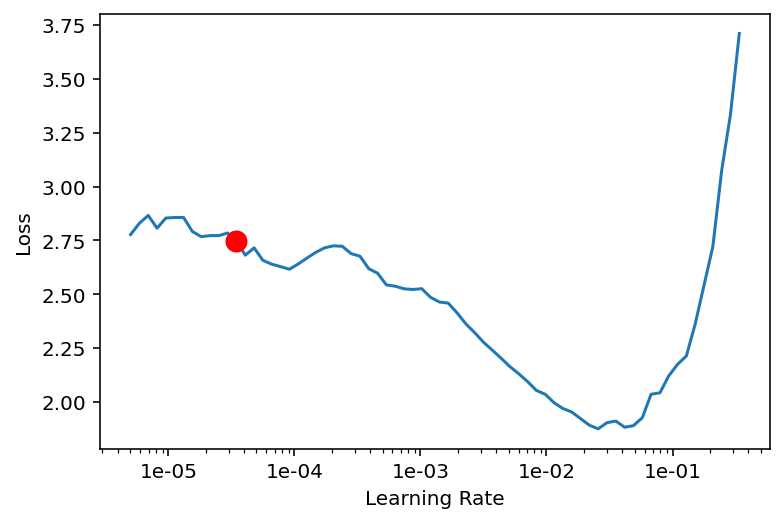

In [21]:
learn.recorder.plot(suggestion=True)

In [22]:
# train the model with 3 epochs and learning rate of 1.35E-02 
# use the suggested learning rate
learn.fit_one_cycle(3,max_lr=1.35e-02)

epoch,train_loss,valid_loss,error_rate,time
0,1.789800,1.968445,0.360396,17:48
1,1.684201,1.031304,0.293069,17:30
2,1.139060,0.583287,0.178218,17:43


learning rate decreases with each epochs. this allows the model to get closer to optimum result. 

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

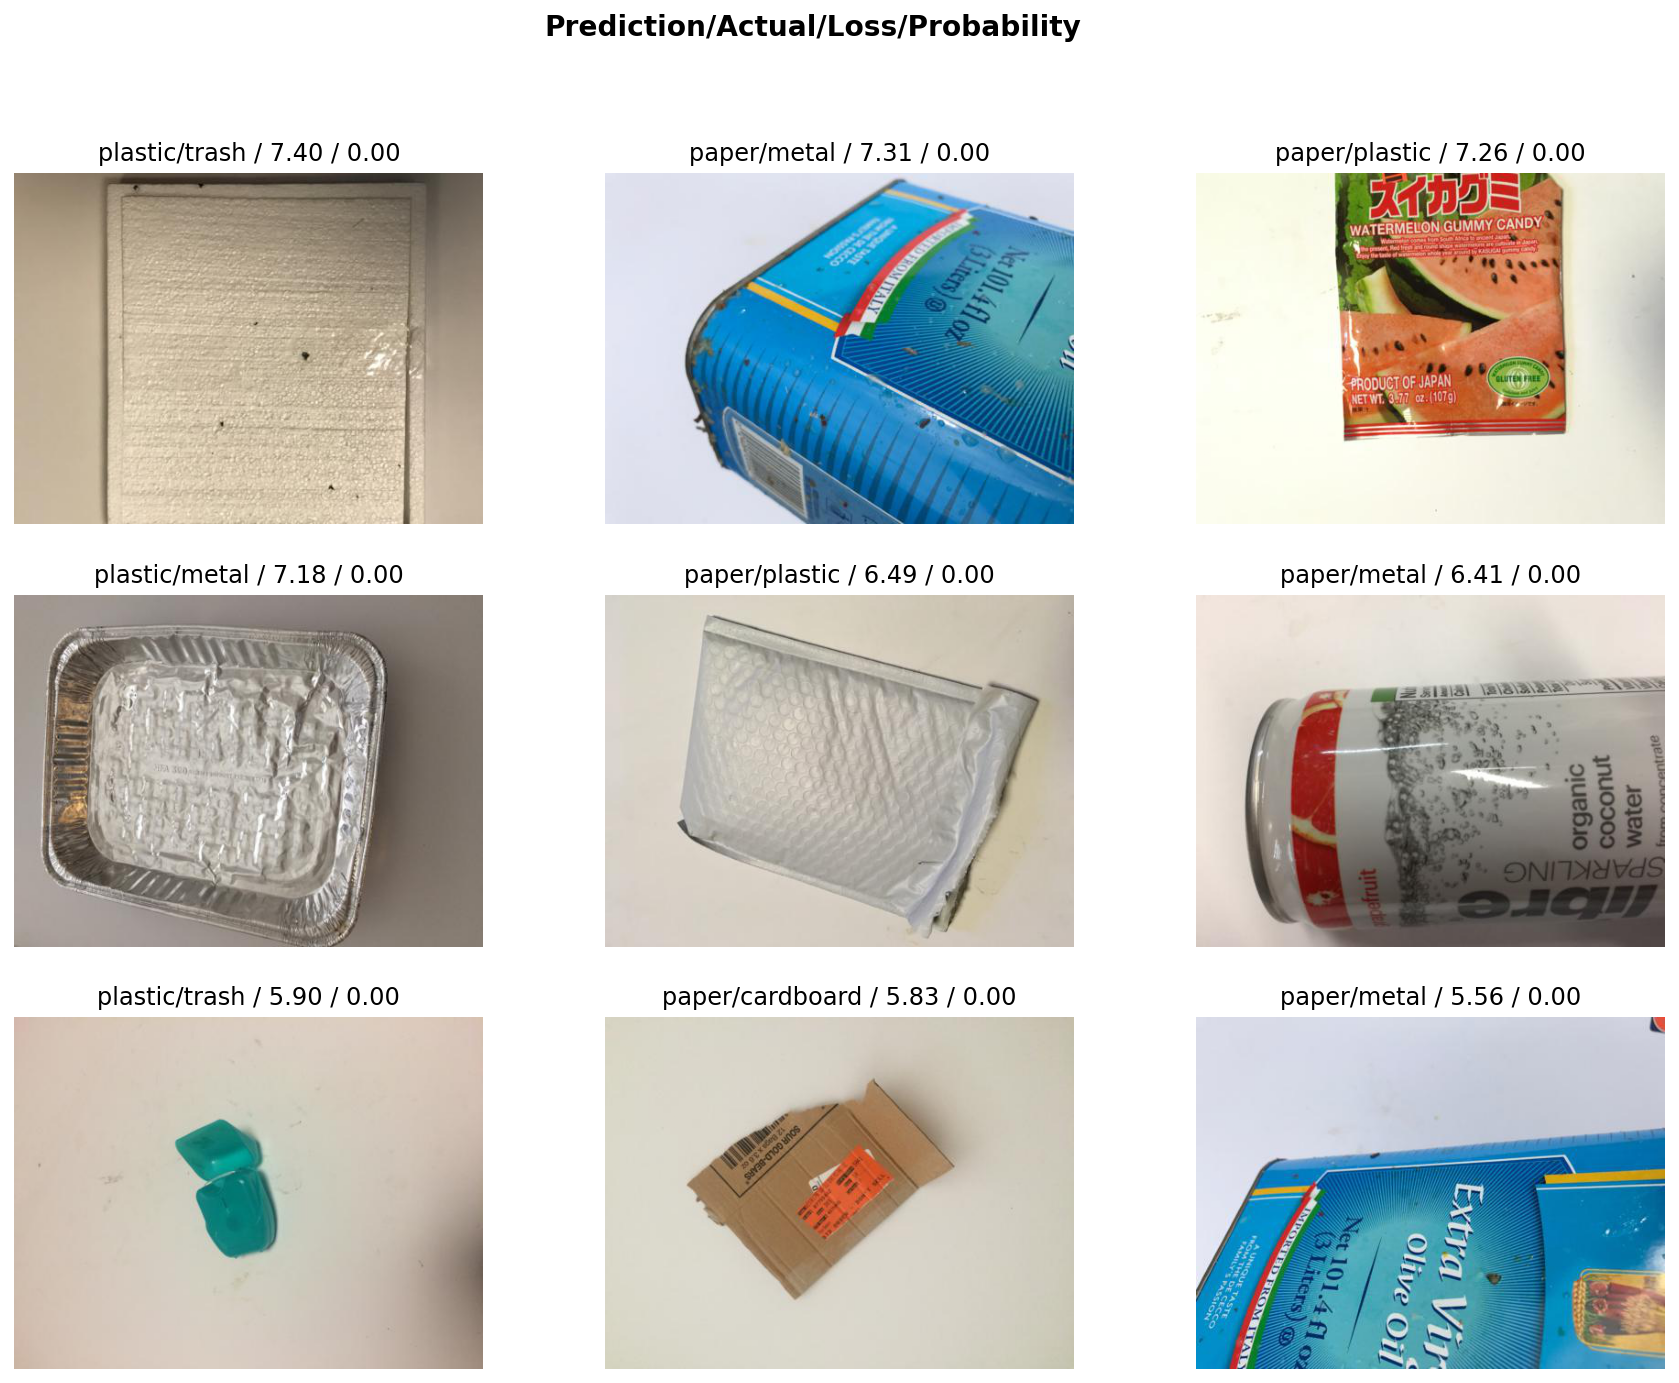

In [24]:
# visualizing most incorrect images
interp.plot_top_losses(9, largest=True, figsize=(15,11))

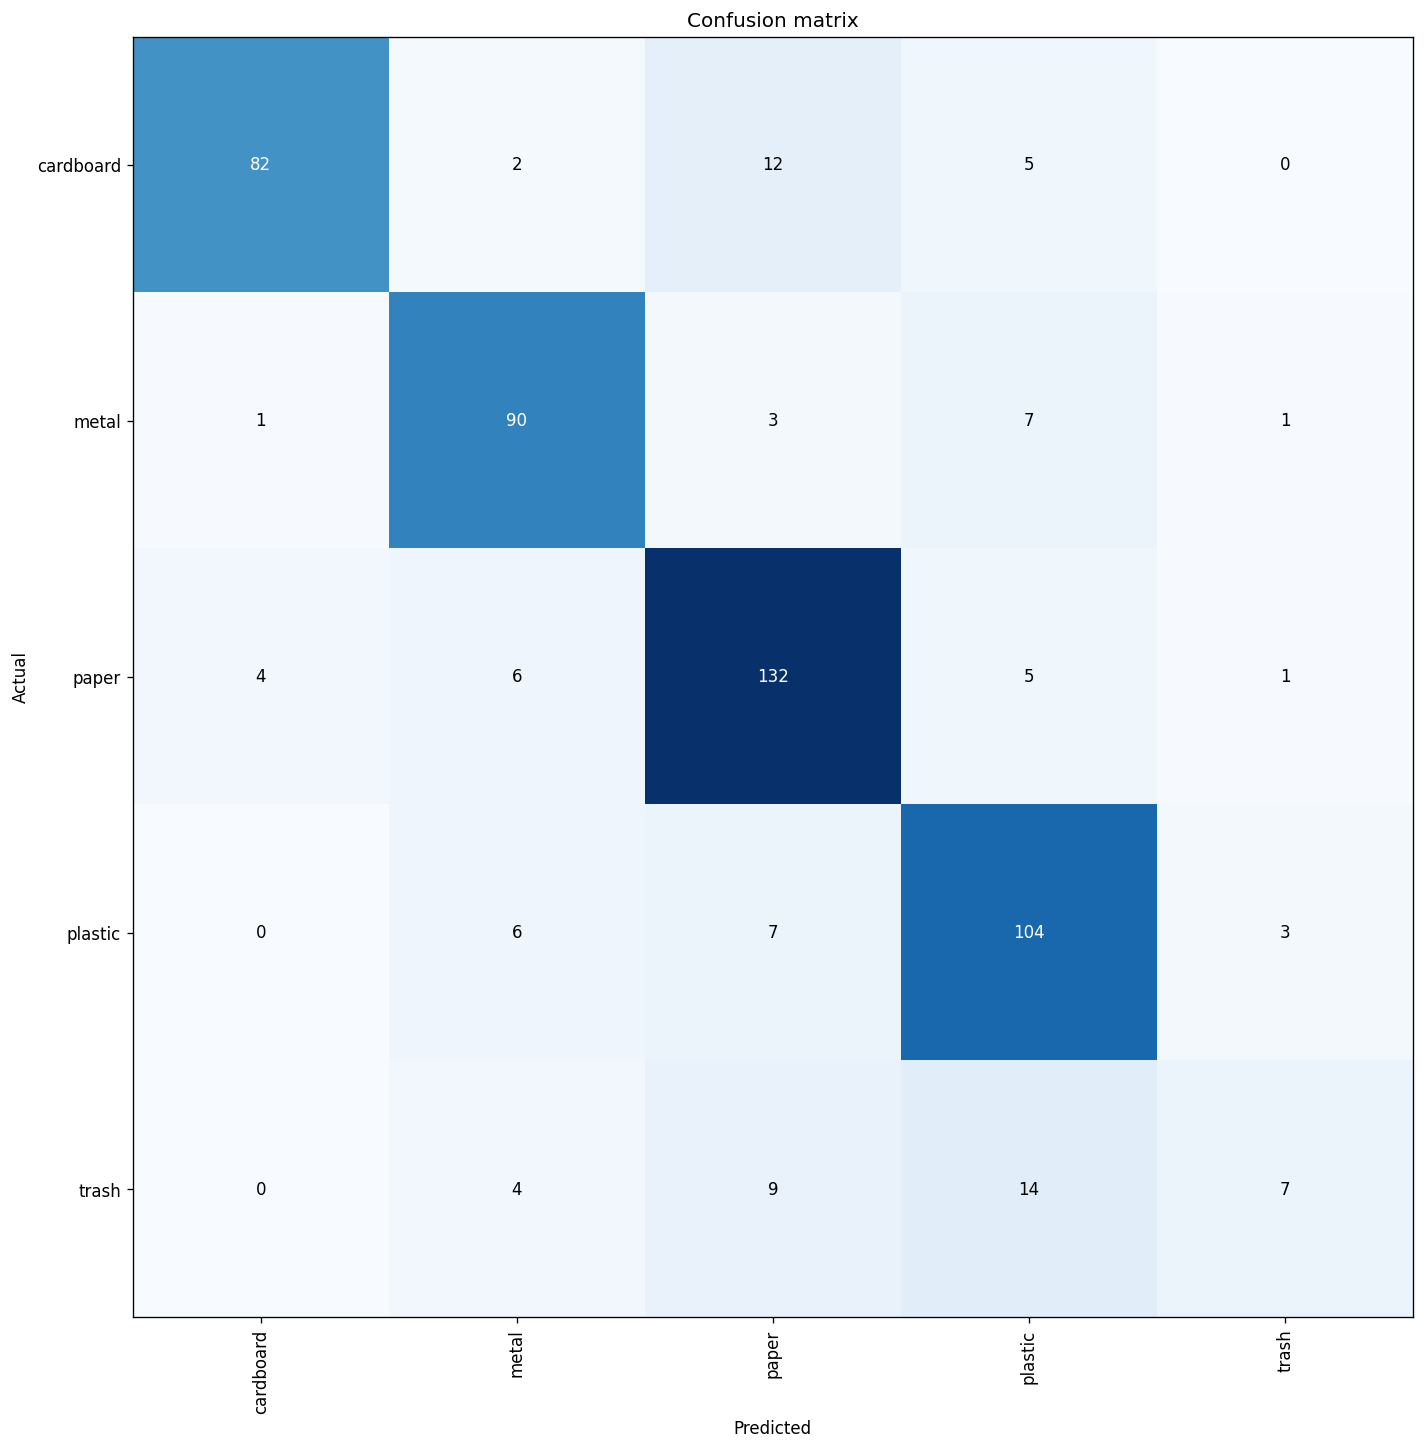

In [25]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

the models still kind of confuses metal as plastic, paper as plastic, and paper as cardboard. 

# new data predictions on data test

In [26]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [27]:
print(preds[0].shape)
preds[0]

torch.Size([509, 5])


tensor([[4.7414e-03, 1.6596e-01, 7.5671e-01, 7.0466e-02, 2.1205e-03],
        [1.2109e-07, 9.9994e-01, 1.7989e-06, 5.1432e-05, 4.1869e-06],
        [9.9661e-01, 1.1624e-03, 2.1341e-03, 1.2581e-05, 8.1643e-05],
        ...,
        [1.4209e-04, 9.2245e-08, 9.9986e-01, 5.2752e-07, 3.6968e-07],
        [5.5685e-01, 3.2644e-05, 4.4152e-01, 3.7646e-05, 1.5634e-03],
        [1.2038e-03, 7.4088e-03, 9.8852e-01, 1.9668e-03, 9.0237e-04]])

In [28]:
data.classes

['cardboard', 'metal', 'paper', 'plastic', 'trash']

In [29]:
## saves the index (0 to 5) of most likely (max) predicted class for each image

max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [30]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [31]:
yhat

['paper',
 'metal',
 'cardboard',
 'metal',
 'paper',
 'paper',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'metal',
 'cardboard',
 'cardboard',
 'metal',
 'plastic',
 'paper',
 'paper',
 'metal',
 'metal',
 'paper',
 'cardboard',
 'plastic',
 'metal',
 'paper',
 'plastic',
 'cardboard',
 'trash',
 'paper',
 'cardboard',
 'metal',
 'plastic',
 'paper',
 'metal',
 'plastic',
 'paper',
 'paper',
 'paper',
 'plastic',
 'metal',
 'plastic',
 'paper',
 'plastic',
 'cardboard',
 'cardboard',
 'cardboard',
 'paper',
 'cardboard',
 'paper',
 'plastic',
 'cardboard',
 'metal',
 'plastic',
 'paper',
 'metal',
 'cardboard',
 'paper',
 'plastic',
 'paper',
 'paper',
 'paper',
 'plastic',
 'metal',
 'paper',
 'plastic',
 'metal',
 'paper',
 'plastic',
 'metal',
 'metal',
 'metal',
 'metal',
 'paper',
 'metal',
 'cardboard',
 'cardboard',
 'cardboard',
 'plastic',
 'paper',
 'metal',
 'metal',
 'paper',
 'plastic',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'paper',
 'paper',
 'paper',
 'metal'

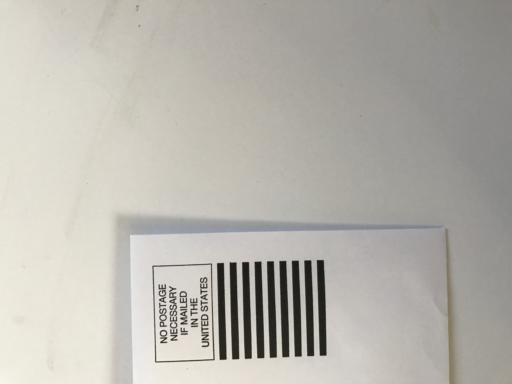

In [32]:
learn.data.test_ds[0][0]

In [33]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [34]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['paper', 'metal', 'cardboard', 'metal', 'paper']
['paper', 'metal', 'cardboard', 'cardboard', 'paper']


the predictions match up 4 of 5 data tests

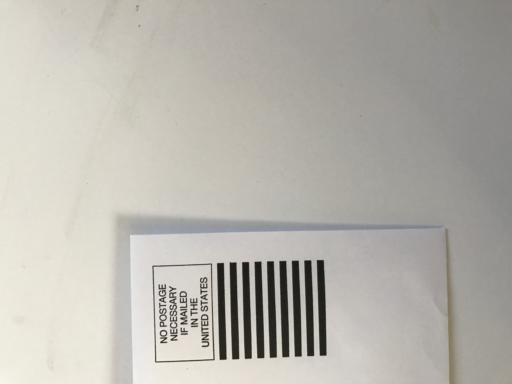

In [35]:
learn.data.test_ds[0][0]

In [36]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 81   6   7   5   2]
 [  1  79   7  16   0]
 [  1   5 136   4   3]
 [  0   9   5 106   1]
 [  0  11   6   8  10]]


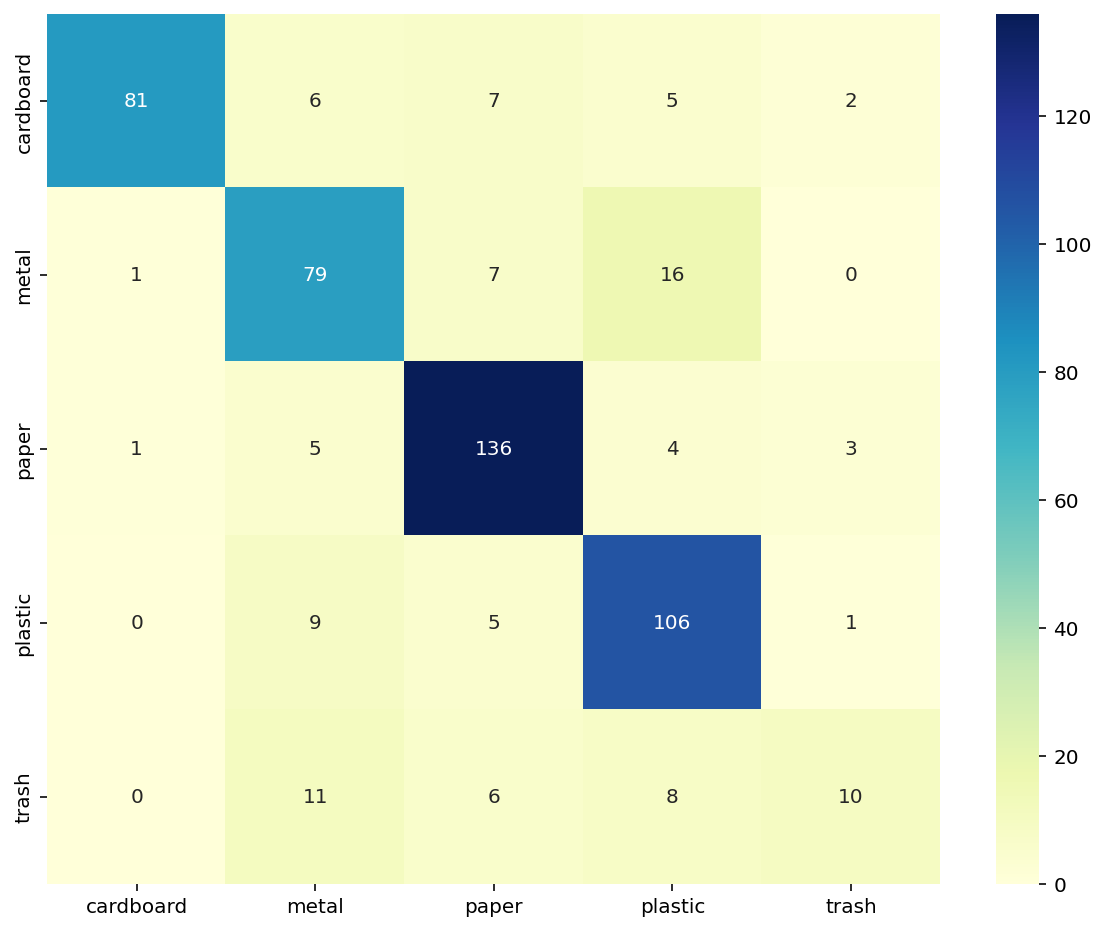

In [37]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [38]:
# to know most confused images
interp.most_confused(min_val=2)

[('trash', 'plastic', 14),
 ('cardboard', 'paper', 12),
 ('trash', 'paper', 9),
 ('metal', 'plastic', 7),
 ('plastic', 'paper', 7),
 ('paper', 'metal', 6),
 ('plastic', 'metal', 6),
 ('cardboard', 'plastic', 5),
 ('paper', 'plastic', 5),
 ('paper', 'cardboard', 4),
 ('trash', 'metal', 4),
 ('metal', 'paper', 3),
 ('plastic', 'trash', 3),
 ('cardboard', 'metal', 2)]

the result of data test still confuse plastic as paper, and cardboard as paper the most.

In [39]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [40]:
accuracy = correct/sum(sum(cm))
accuracy

0.8094302554027505